# MonoLingual - without FineTune

In [2]:
import os
from gensim.models import KeyedVectors

english_embedding_path = "C:/Users/ALI/Desktop/wikis/wiki.en.vec"
arabic_embedding_path = "C:/Users/ALI/Desktop/wikis/Arabic fastText/wiki.ar.vec"

en_embeddings = KeyedVectors.load_word2vec_format(english_embedding_path)
ar_embeddings = KeyedVectors.load_word2vec_format(arabic_embedding_path)

In [3]:
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD

def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings

In [5]:
import keras
import argparse
import sys
import fasttext as fastText
import math
import linecache
import numpy as np 
from numpy import random
from random import sample
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras import *
import keras
from keras.utils import to_categorical
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.initializers import RandomUniform
import re
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pandas as pd
# from keras.backend import set_session
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)
# tf.compat.v1.keras.backend.set_session(session)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')


In [7]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Modify the Model Output Layer

In [8]:
def compile_model_bilstm_cnn():
    model_input_embedding = Input(shape=(nb_sequence_length, nb_embedding_dims))
    lstm_block = Bidirectional(LSTM(100, dropout=0.5, return_sequences=True))(model_input_embedding)
    lstm_block = LeakyReLU()(lstm_block)

    filter_sizes = (3, 4, 5)
    conv_blocks = []
    for sz in filter_sizes:
        conv = Conv1D(
            filters=200,
            kernel_size=sz,
            padding='valid',
            strides=1
        )(lstm_block)
        conv = LeakyReLU()(conv)
        conv = GlobalMaxPooling1D()(conv)
        conv = Dropout(0.5)(conv)
        conv_blocks.append(conv)
    model_concatenated = concatenate([conv_blocks[0], conv_blocks[1], conv_blocks[2]])
    model_concatenated = Dense(100)(model_concatenated)
    model_concatenated = LeakyReLU()(model_concatenated)
    model_output = Dense(1, activation='sigmoid')(model_concatenated)
    new_model = Model(model_input_embedding, model_output)
    new_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    new_model.summary()
    return new_model

# Train on IMDB Dataset

In [9]:
# load the IMDB dataset
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')
def map_sentiment(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment_'] = df['sentiment'].apply(map_sentiment)# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['english_Embeddings'] = reviews_embeddings
df

,review,sentiment,sentiment_,english_Embeddings
0,One of the other reviewers has mentioned that ...,positive,1,"[-0.03771015969640335, -0.05301021337614868, -..."
1,A wonderful little production. <br /><br />The...,positive,1,"[-0.03921904056694094, -0.05542069860558668, -..."
2,I thought this was a wonderful way to spend ti...,positive,1,"[-0.06706067933831186, -0.03774270410073028, -..."
3,Basically there's a family where a little boy ...,negative,0,"[-0.03542590748349525, -0.0753983760105298, -0..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"[-0.034642417387586694, -0.030091569139120755,..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,"[-0.06425526303249209, -0.02913804802489772, -..."
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,"[-0.06110306415572484, -0.05485152410638843, -..."
49997,I am a Catholic taught in parochial elementary...,negative,0,"[-0.026716567214734817, -0.05318198237643865, ..."
49998,I'm going to have to disagree with the previou...,negative,0,"[-0.05828559653520417, -0.0513771508124303, -0..."


In [10]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, concatenate, LeakyReLU
from keras.utils import to_categorical

# set hyperparameters
ft = fastText.load_model("C:/Users/ALI/Desktop/wikis/wiki.en.bin")
nb_embedding_dims = ft.get_dimension()
nb_sequence_length = 75
nb_epochs = 10
batch_size = 64

# load the IMDB dataset
# imdb_df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')
imdb_df = df
# tokenization function for IMDB dataset
def imdb_tokenizer(textline):
    words = textline.split()
    words = [w.strip() for w in words if w.strip() != '']
    return words

def process_features_imdb(embedding_vector, nb_sequence_length, nb_embedding_dims):
    features = np.zeros((nb_sequence_length, nb_embedding_dims))
    for i in range(nb_embedding_dims):
        features[:,i] = embedding_vector[i]
    return features

# # create dict of IMDB word embeddings
imdb_embeddings = {}

# train/dev split for IMDB dataset
train_df = imdb_df.sample(frac=0.8, random_state=42)
dev_df = imdb_df.drop(train_df.index)

# preprocess the training set
train_features = []
train_labels = []
for i, row in train_df.iterrows():
    review = row['english_Embeddings']
    label = row['sentiment']
    features = process_features_imdb(review, nb_sequence_length, nb_embedding_dims)
    if features is not None:
        train_features.append(features)
        train_labels.append(1 if label == 'positive' else 0)

train_features = np.array(train_features)
train_labels = np.array(train_labels)

# preprocess the dev set
dev_features = []
dev_labels = []
for i, row in dev_df.iterrows():
    review = row['english_Embeddings']
    label = row['sentiment']
    features = process_features_imdb(review, nb_sequence_length, nb_embedding_dims)
    if features is not None:
        dev_features.append(features)
        dev_labels.append(1 if label == 'positive' else 0)

dev_features = np.array(dev_features)
dev_labels = np.array(dev_labels)

model_input_embedding = Input(shape=(nb_sequence_length, nb_embedding_dims))
lstm_block = Bidirectional(LSTM(100, dropout=0.5, return_sequences=True))(model_input_embedding)
lstm_block = LeakyReLU()(lstm_block)

filter_sizes = (3, 4, 5)
conv_blocks = []
for sz in filter_sizes:
    conv = Conv1D(
        filters=200,
        kernel_size=sz,
        padding='valid',
        strides=1
    )(lstm_block)
    conv = LeakyReLU()(conv)
    conv = GlobalMaxPooling1D()(conv)
    conv = Dropout(0.5)(conv)
    conv_blocks.append(conv)
model_concatenated = concatenate([conv_blocks[0], conv_blocks[1], conv_blocks[2]])
model_concatenated = Dense(100)(model_concatenated)
model_concatenated = LeakyReLU()(model_concatenated)

model_output = Dense(1, activation='sigmoid')(model_concatenated)
new_model = Model(model_input_embedding, model_output)
new_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
new_model.summary()


model = new_model

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(train_features, train_labels, epochs=nb_epochs, batch_size=batch_size, validation_data=(dev_features, dev_labels))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 300)]            0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 75, 200)              320800    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 75, 200)              0         ['bidirectional[0][0]']       
                                                                                                  
 conv1d (Conv1D)             (None, 73, 200)              120200    ['leaky_re_lu[0][0]']     

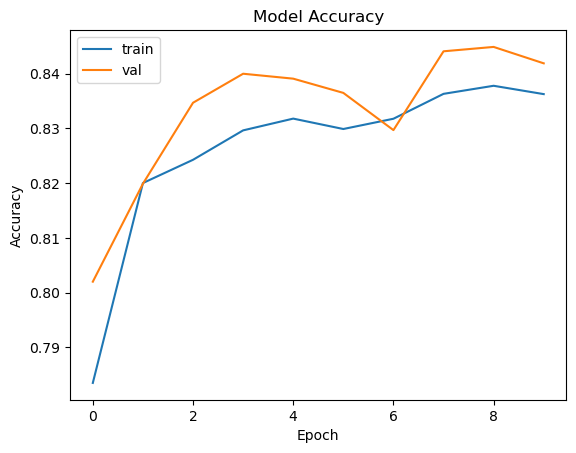

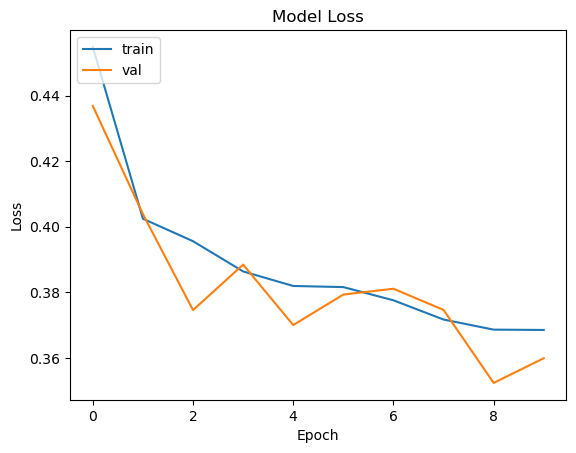

In [14]:
import matplotlib.pyplot as plt
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# model.save('semeval_model_BiLSTM_3CNN.h5')
model.save('semeval_model_BiLSTM_3CNN_Emb_mono_.h5')

C:\Users\ALI\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Arabic Fine Tune - Test

In [16]:
from tensorflow.keras.models import load_model

loaded_model = load_model('semeval_model_BiLSTM_3CNN_Emb_mono_.h5')

In [17]:
df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return 0
    elif rating in [4, 5]:
        return 1
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings
df

,no,Hotel name,rating,user type,room type,nights,review,sentiment,arabic_Embeddings
0,3095,Africana Hotel,1,-,غرفة ثلاثية,أقمت ليلتين,ضعيف جداً. . معاملة موظفين الاستقبال سيئة جدا,0,"[-0.02224975066191187, -0.023650155061107393, ..."
1,2376,أداجيو أبوظبي البستان,1,أسرة,-,أقمت ليلة واحدة,“لا يصلح للاقامة”. لا شى. كل شي,0,"[-0.01463423013598405, -0.07710449624493591, -..."
2,3385,فندق ومنتجع ون تو ون عين الفايضة,1,أسرة,-,أقمت ليلة واحدة,“غير ملتزمين بالفيلا التى حجزتها من موقع غيرو...,0,"[-0.08393003450228523, -0.10652140894347145, -..."
3,3082,Africana Hotel,1,-,غرفة ثلاثية,أقمت 3 ليالي,ضعيف جداً. . عدم توافر مواقف السيارات تابعة لل...,0,"[-0.016593602700778826, -0.11224795963795059, ..."
4,3171,فندق ومنتجع ون تو ون عين الفايضة,1,أسرة,-,أقمت 3 ليالي,“فندق”. لا شئ فندق سئ. لا يوجد مطبخ يوجد فقط ح...,0,"[-0.1343201574255168, -0.0074934209974068106, ..."
...,...,...,...,...,...,...,...,...,...
155,2633,اداجيو بريميوم البرشاء,5,مسافر منفرد,شقة من غرفة نوم واحدة,أقمت 7 ليالي,ممتاز. الموقع ممتازطاقم العمل رائع ومتعاوناجار...,1,"[-0.1491557239795682, -0.06947365673903928, -0..."
156,2888,فندق عفراء,5,أسرة,غرفة رباعية,أقمت ليلة واحدة,“روعه”. الفندق قمة في الروعه بس يوجد ثلاث ملاح...,1,"[-0.06364731075664855, 0.009834764897725654, -..."
157,2201,فندق اكاسيا باي بن ماجد هوتيلز آند ريزورتس,5,زوج,غرفة مزدوجة أو توأم,أقمت ليلة واحدة,“اكاسيا وابراهيم وبس”. موظف الاستقبال ابراهيم ...,1,"[-0.05596199955889458, -0.08691045817080095, -..."
158,2499,الشقق الفندقية أداجيو الفجيرة,5,أسرة,-,أقمت ليلتين,استثنائي. كل شي اعجبني الاستقبال المعامله الهد...,1,"[-0.07663860333103154, -0.09333178518236225, -..."


In [18]:
def get_model_Sentiment(input_embeddings_):
#     input_embeddings_ = df['arabic_Embeddings'][0]

    # reshape the list into a 2D array with 1 row and 300 columns
    second_array = np.array(input_embeddings_).reshape(1, 300)

    # repeat the 1-row array into a 75-row array
    second_array = np.repeat(second_array, 75, axis=0)

    input_array = np.array([second_array])

    # Predict the sentiment using the model
    predicted_probs = loaded_model.predict(input_array)

    label_index_to_sentiment = {0: 'positive', 1: 'negative', 2: 'neutral'}

    # Convert the predicted probabilities to class labels
    predicted_label_index = np.argmax(predicted_probs)
    predicted_label = label_index_to_sentiment[predicted_label_index]

    print(f"The predicted sentiment of the input sentence is {predicted_label_index}.")
    return predicted_label_index


In [19]:
get_model_Sentiment( df['arabic_Embeddings'][0])

1/1 [==============================] - 1s 722ms/step
The predicted sentiment of the input sentence is 0.


0

# Test on x_test before and after Fine tune

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(df['arabic_Embeddings']) 
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_processed_arrays = []

for x_tr in X_train:
    X_train_ = np.array(x_tr).reshape(1, 300)
    X_train_ = np.repeat(X_train_, 75, axis=0)
    X_train_ = np.array([X_train_])
    
    X_train_processed_arrays.append(X_train_)

# Concatenate the processed arrays along the first axis to create a single 2D array
X_train_concatenated_array = np.concatenate(X_train_processed_arrays, axis=0)
X_train_concatenated_array

array([[[-0.03825931, -0.05702082, -0.08643096, ..., -0.02483974,
          0.01381868,  0.04209769],
        [-0.03825931, -0.05702082, -0.08643096, ..., -0.02483974,
          0.01381868,  0.04209769],
        [-0.03825931, -0.05702082, -0.08643096, ..., -0.02483974,
          0.01381868,  0.04209769],
        ...,
        [-0.03825931, -0.05702082, -0.08643096, ..., -0.02483974,
          0.01381868,  0.04209769],
        [-0.03825931, -0.05702082, -0.08643096, ..., -0.02483974,
          0.01381868,  0.04209769],
        [-0.03825931, -0.05702082, -0.08643096, ..., -0.02483974,
          0.01381868,  0.04209769]],

       [[-0.04341589, -0.07545888, -0.12950205, ...,  0.03113265,
          0.08861196,  0.14027739],
        [-0.04341589, -0.07545888, -0.12950205, ...,  0.03113265,
          0.08861196,  0.14027739],
        [-0.04341589, -0.07545888, -0.12950205, ...,  0.03113265,
          0.08861196,  0.14027739],
        ...,
        [-0.04341589, -0.07545888, -0.12950205, ...,  

In [23]:
X_test_processed_arrays = []

for x_ts in X_test:
    X_test_ = np.array(x_ts).reshape(1, 300)
    X_test_ = np.repeat(X_test_, 75, axis=0)
    X_test_ = np.array([X_test_])
    
    X_test_processed_arrays.append(X_test_)

# Concatenate the processed arrays along the first axis to create a single 2D array
X_test_concatenated_array = np.concatenate(X_test_processed_arrays, axis=0)
X_test_concatenated_array

array([[[-0.01485276, -0.05269437, -0.06534779, ...,  0.0626613 ,
         -0.20069763,  0.04324268],
        [-0.01485276, -0.05269437, -0.06534779, ...,  0.0626613 ,
         -0.20069763,  0.04324268],
        [-0.01485276, -0.05269437, -0.06534779, ...,  0.0626613 ,
         -0.20069763,  0.04324268],
        ...,
        [-0.01485276, -0.05269437, -0.06534779, ...,  0.0626613 ,
         -0.20069763,  0.04324268],
        [-0.01485276, -0.05269437, -0.06534779, ...,  0.0626613 ,
         -0.20069763,  0.04324268],
        [-0.01485276, -0.05269437, -0.06534779, ...,  0.0626613 ,
         -0.20069763,  0.04324268]],

       [[-0.04964578, -0.01932389, -0.09758806, ..., -0.09289632,
         -0.05802743,  0.08062637],
        [-0.04964578, -0.01932389, -0.09758806, ..., -0.09289632,
         -0.05802743,  0.08062637],
        [-0.04964578, -0.01932389, -0.09758806, ..., -0.09289632,
         -0.05802743,  0.08062637],
        ...,
        [-0.04964578, -0.01932389, -0.09758806, ..., -

In [24]:

# Evaluate the performance of the SVM on the testing set
y_pred = loaded_model.predict(X_test_concatenated_array)

y_pred

1/1 [==============================] - 0s 61ms/step


array([[0.99939066],
       [0.99760264],
       [0.9994686 ],
       [0.9586432 ],
       [0.9999907 ],
       [0.99997526],
       [0.9998333 ],
       [0.99999815],
       [0.9926211 ],
       [0.9999979 ],
       [0.9999933 ],
       [0.99593794],
       [0.99987185],
       [0.9993221 ],
       [0.99997723],
       [0.99988604],
       [0.99984896],
       [0.9981817 ],
       [0.9970589 ],
       [0.9999608 ],
       [0.9973617 ],
       [0.99999374],
       [0.99739224],
       [0.84384865],
       [0.16495214],
       [0.02303401],
       [0.9998728 ],
       [0.99310756],
       [0.02987442],
       [0.9999825 ],
       [0.98761165],
       [0.00564   ]], dtype=float32)

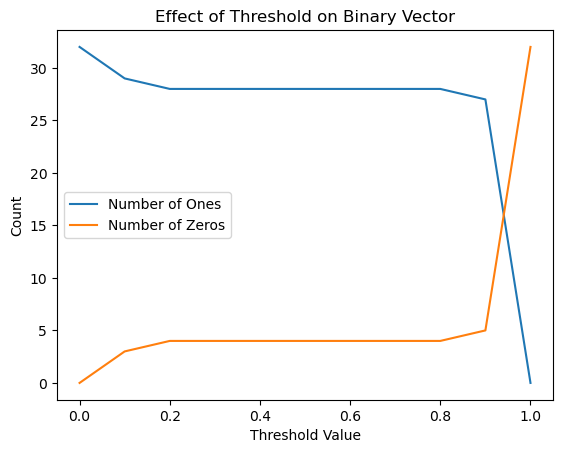

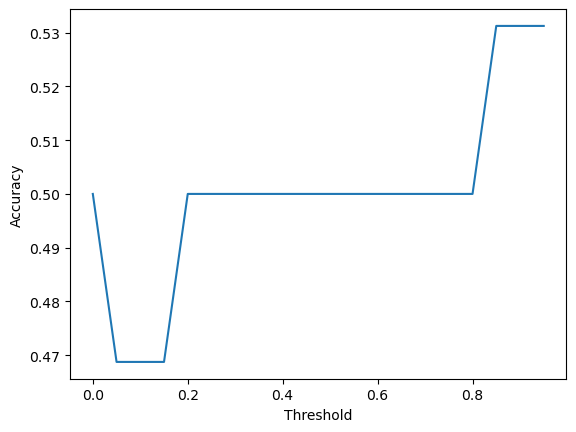

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def threshold_array(arr, threshold):
    return np.array([1 if x >= threshold else 0 for x in arr])

# Example usage
arr = y_pred

threshold_values = np.linspace(0, 1, num=11)
num_ones = []
num_zeros = []

for threshold in threshold_values:
    thresholded_arr = threshold_array(arr, threshold)
    num_ones.append(np.sum(thresholded_arr))
    num_zeros.append(len(thresholded_arr) - np.sum(thresholded_arr))

plt.plot(threshold_values, num_ones, label='Number of Ones')
plt.plot(threshold_values, num_zeros, label='Number of Zeros')
plt.xlabel('Threshold Value')
plt.ylabel('Count')
plt.title('Effect of Threshold on Binary Vector')
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# create a sample binary array and corresponding true labels
bin_arr = y_pred
labels = y_test

# define a range of threshold values to test
thresholds = np.arange(0, 1.0, 0.05)

# calculate the accuracy for each threshold value
accuracies = []
for threshold in thresholds:
    pred_labels = np.where(bin_arr > threshold, 1, 0)
    accuracy = accuracy_score(labels, pred_labels)
#     print(accuracy)
    accuracies.append(accuracy)

# plot the threshold values against the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [26]:
# Find the maximum accuracy
max_accuracy = max(accuracies)

# Find the corresponding threshold value for the maximum accuracy
max_threshold = thresholds[accuracies.index(max_accuracy)]

# Print the maximum accuracy and corresponding threshold value
print("Maximum accuracy:", max_accuracy)
print("Corresponding threshold value:", max_threshold)

Maximum accuracy: 0.53125
Corresponding threshold value: 0.8500000000000001


In [27]:
from sklearn.metrics import classification_report
# Evaluate the performance of the model on the testing set
y_pred = loaded_model.predict(X_test_concatenated_array)
y_pred = (y_pred > max_threshold).astype(int)
print(classification_report(y_test, y_pred))

1/1 [==============================] - 0s 49ms/step
              precision    recall  f1-score   support

           0       0.60      0.19      0.29        16
           1       0.52      0.88      0.65        16

    accuracy                           0.53        32
   macro avg       0.56      0.53      0.47        32
weighted avg       0.56      0.53      0.47        32



In [29]:
snn = loaded_model.fit(X_train_concatenated_array, y_train)


4/4 [==============================] - 3s 139ms/step - loss: 2.2675 - accuracy: 0.4844


1/1 [==============================] - 0s 62ms/step


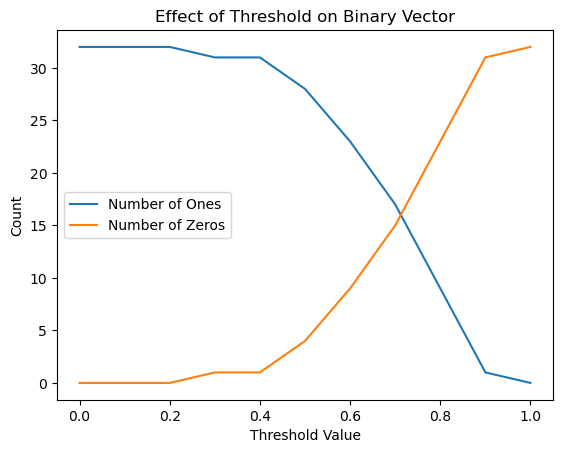

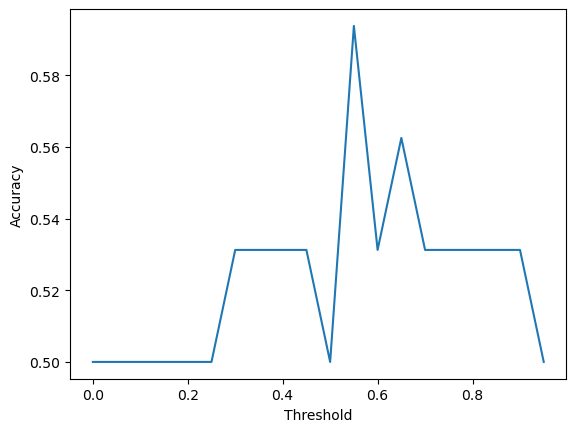

Maximum accuracy: 0.59375
Corresponding threshold value: 0.55


In [30]:
y_pred = loaded_model.predict(X_test_concatenated_array)
import numpy as np
import matplotlib.pyplot as plt

def threshold_array(arr, threshold):
    return np.array([1 if x >= threshold else 0 for x in arr])

# Example usage
arr = y_pred

threshold_values = np.linspace(0, 1, num=11)
num_ones = []
num_zeros = []

for threshold in threshold_values:
    thresholded_arr = threshold_array(arr, threshold)
    num_ones.append(np.sum(thresholded_arr))
    num_zeros.append(len(thresholded_arr) - np.sum(thresholded_arr))

plt.plot(threshold_values, num_ones, label='Number of Ones')
plt.plot(threshold_values, num_zeros, label='Number of Zeros')
plt.xlabel('Threshold Value')
plt.ylabel('Count')
plt.title('Effect of Threshold on Binary Vector')
plt.legend()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# create a sample binary array and corresponding true labels
bin_arr = y_pred
labels = y_test

# define a range of threshold values to test
thresholds = np.arange(0, 1.0, 0.05)

# calculate the accuracy for each threshold value
accuracies = []
for threshold in thresholds:
    pred_labels = np.where(bin_arr > threshold, 1, 0)
    accuracy = accuracy_score(labels, pred_labels)
#     print(accuracy)
    accuracies.append(accuracy)

# plot the threshold values against the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

# Find the maximum accuracy
max_accuracy = max(accuracies)

# Find the corresponding threshold value for the maximum accuracy
max_threshold = thresholds[accuracies.index(max_accuracy)]

# Print the maximum accuracy and corresponding threshold value
print("Maximum accuracy:", max_accuracy)
print("Corresponding threshold value:", max_threshold)

In [31]:
from sklearn.metrics import classification_report
# Evaluate the performance of the model on the testing set
y_pred = loaded_model.predict(X_test_concatenated_array)
y_pred = (y_pred > max_threshold).astype(int)
print(classification_report(y_test, y_pred))

1/1 [==============================] - 0s 70ms/step
              precision    recall  f1-score   support

           0       0.71      0.31      0.43        16
           1       0.56      0.88      0.68        16

    accuracy                           0.59        32
   macro avg       0.64      0.59      0.56        32
weighted avg       0.64      0.59      0.56        32

